# Sentiment Analysis Using NLTK with Short Movie Reviews - Training

The code has been taken from the source https://pythonprogramming.net as part of my learning journey. Furhter I have modified the code in part to suit model training etc. Please refer to the source for complete tutorials on NLP using NLTK

In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
# nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon

import pickle

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from statistics import mode
from sklearn.model_selection import train_test_split

In [2]:
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

## Read in the positive and negative reviews

In [3]:
short_pos = open("short_reviews/positive.txt","r").read()
short_neg = open("short_reviews/negative.txt","r").read()

In [4]:
all_words = []
documents = []
word_tags = []

## Parts of speech tagging

In [5]:
allowed_word_types = ["J","R","V"]
# j is adject, r is adverb, and v is verb

#### The following cell does the following tasks
1. Split the positive and negative strings and separates then using a new line character
2. Create a list of tuples with the review and give it a 'pos' or 'neg' classification
3. Tokenize the words
4. Tag the words with pats of speech
5. Filter out anything other than adjectives, adverbs and verbs
6. Append the words to all_words while converting them to lower case

In [6]:
for p in short_pos.split('\n'):
    documents.append( (p, "pos") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    word_tags.append(nltk.pos_tag(words))
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())
    
for p in short_neg.split('\n'):
    documents.append( (p, "neg") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    word_tags.append(nltk.pos_tag(words))
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

NLTK's FreqDist generates a frequency distribution of the words as a key, value pairs with keys as the words and values as the count of the word

In [7]:
all_words = nltk.FreqDist(all_words)

<FreqDist with 11310 samples and 71206 outcomes>
is : 3558
's : 1709
n't : 940
be : 939
not : 831
are : 733
has : 730
more : 728
have : 640
so : 523
too : 459
just : 438
does : 417
most : 402
much : 386


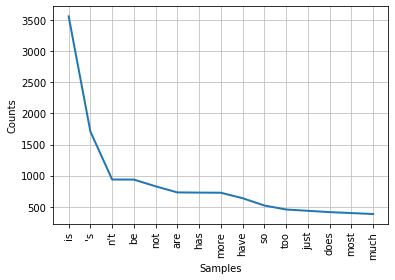

In [8]:
print(all_words)

for word, frequency in all_words.most_common(15):
    print(u'{} : {}'.format(word, frequency))
    
all_words.plot(15)

Use the keys() method to get all the words which will form the features of our dataset

As we can see from the above the all_words has about 11310 samples. We can either use all these as features or choose the most common 'n' (say 1500). The following cell shows how to get the most common 1500 but for this exercise we will use all the words

In [9]:
all_words_most_common_1500 = all_words.most_common(1500)
print(all_words_most_common_1500[0:10])

word_features_1500 = list(dict(all_words_most_common_1500).keys())
print(word_features_1500[0:10])

[('is', 3558), ("'s", 1709), ("n't", 940), ('be', 939), ('not', 831), ('are', 733), ('has', 730), ('more', 728), ('have', 640), ('so', 523)]
['is', "'s", "n't", 'be', 'not', 'are', 'has', 'more', 'have', 'so']


In [10]:
word_features = list(all_words.keys())
print(word_features[0:10])

['is', 'destined', 'be', '21st', 'new', 'conan', "'s", 'going', 'make', 'even']


Define a function which takes a document, tokenizes it and then finds words/ features from it which exist in word_features

In [11]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

The next step is to convert our document to featuresets. Each record from the document is converted to a set of features and our target classification

In [12]:
featuresets = [(find_features(rev), category) for (rev, category) in documents]

In [13]:
random.seed(143)
random.shuffle(featuresets)
print(len(featuresets))
print (featuresets[0])

10664
({'is': True, 'destined': False, 'be': False, '21st': False, 'new': False, 'conan': False, "'s": False, 'going': False, 'make': False, 'even': False, 'greater': False, 'arnold': False, 'jean-claud': False, 'steven': False, 'gorgeously': False, 'elaborate': False, 'so': False, 'huge': False, 'not': False, 'adequately': False, 'describe': False, 'expanded': False, 'effective': False, 'too-tepid': False, 'sometimes': False, 'go': False, 'have': False, 'good': False, 'start': False, 'rare': False, 'honest': False, 'keenly': False, 'observed': False, 'does': False, "n't": False, 'feel': False, 'provides': False, 'great': False, 'neurotic': False, 'reached': False, 'absolute': False, 'perhaps': False, 'ever': True, 'made': False, 'has': True, 'more': True, 'literally': False, 'showed': False, 'hell': False, 'paved': False, 'turns': False, 'snappy': False, 'curls': False, 'clever': False, 'want': False, 'hate': False, 'somehow': False, 'pulls': False, 'off': False, 'take': False, 'offer

In [14]:
testing_set = featuresets[10000:]
training_set = featuresets[:10000]

In [15]:
print(len(testing_set))
print(len(training_set))

664
10000


## NLTK's Naive Bayes Classifier

In [16]:
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

Original Naive Bayes Algo accuracy percent: 79.66867469879519
Most Informative Features
              engrossing = True              pos : neg    =     21.0 : 1.0
                  stupid = True              neg : pos    =     18.4 : 1.0
                 generic = True              neg : pos    =     16.4 : 1.0
                 routine = True              neg : pos    =     16.4 : 1.0
               inventive = True              pos : neg    =     15.0 : 1.0
                  boring = True              neg : pos    =     14.7 : 1.0
                supposed = True              neg : pos    =     14.4 : 1.0
              refreshing = True              pos : neg    =     14.3 : 1.0
                    flat = True              neg : pos    =     13.8 : 1.0
            refreshingly = True              pos : neg    =     13.0 : 1.0
               wonderful = True              pos : neg    =     12.2 : 1.0
                    warm = True              pos : neg    =     12.2 : 1.0
            

## Multinominal NB

In [17]:
alphas = [0.0, 0.01, 0.1, 0.9, 1.0, 10]
for alpha in alphas:
    MNB_classifier = SklearnClassifier(MultinomialNB(alpha=alpha, fit_prior=False))
    MNB_classifier.train(training_set)
    print("MNB_classifier accuracy percent with alpha =  %f: %f" % (alpha, (nltk.classify.accuracy(MNB_classifier, testing_set))*100))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


MNB_classifier accuracy percent with alpha =  0.000000: 77.108434
MNB_classifier accuracy percent with alpha =  0.010000: 77.259036
MNB_classifier accuracy percent with alpha =  0.100000: 79.367470
MNB_classifier accuracy percent with alpha =  0.900000: 79.518072
MNB_classifier accuracy percent with alpha =  1.000000: 79.216867
MNB_classifier accuracy percent with alpha =  10.000000: 77.259036


In [18]:
MNB_classifier = SklearnClassifier(MultinomialNB(alpha=10, fit_prior=False))
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

MNB_classifier accuracy percent: 77.2590361445783


## Bernouli NB

In [19]:
alphas = [0.0, 0.01, 0.1, 0.9, 1.0, 10]
for alpha in alphas:
    BernoulliNB_classifier = SklearnClassifier(BernoulliNB(alpha=alpha, fit_prior=False))
    BernoulliNB_classifier.train(training_set)
    print("BernoulliNB_classifier accuracy percent with alpha =  %f: %f" % (alpha, (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


BernoulliNB_classifier accuracy percent with alpha =  0.000000: 76.807229
BernoulliNB_classifier accuracy percent with alpha =  0.010000: 77.108434
BernoulliNB_classifier accuracy percent with alpha =  0.100000: 79.216867
BernoulliNB_classifier accuracy percent with alpha =  0.900000: 79.216867
BernoulliNB_classifier accuracy percent with alpha =  1.000000: 78.915663
BernoulliNB_classifier accuracy percent with alpha =  10.000000: 76.957831


In [20]:
BernoulliNB_classifier = SklearnClassifier(BernoulliNB(alpha=0.9, fit_prior=False))
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

BernoulliNB_classifier accuracy percent: 79.21686746987952


## Logistic Regression

In [21]:
LogisticRegression_classifier = SklearnClassifier(LogisticRegression(C=0.1, random_state=143))
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression_classifier accuracy percent: 75.75301204819277


## Linear SVC

In [22]:
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

LinearSVC_classifier accuracy percent: 73.19277108433735


## SGD Classifier

In [23]:
SGDC_classifier = SklearnClassifier(SGDClassifier())
SGDC_classifier.train(training_set)
print("SGDClassifier accuracy percent:",nltk.classify.accuracy(SGDC_classifier, testing_set)*100)

SGDClassifier accuracy percent: 74.09638554216868


### Instanciating an object of the class VoteClassifier

In [24]:
voted_classifier = VoteClassifier(
                                  classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

## Function to generate the sentiment

In [25]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats),voted_classifier.confidence(feats)

In [26]:
sentiment("This movie was awesome! The acting was great, plot was wonderful, and there were pythons...so yea!")

('pos', 0.6)

In [27]:
sentiment("This movie was utter junk. There were absolutely 0 pythons. I don't see what the point was at all. Horrible movie, 0/10")

('neg', 1.0)

## Pickle/ Save Documents, Features, Featuresets, Classifiers

As it takes a long and effort to train the algorithms it is good to save them to the drive so that they can be loaded when required and used

In [28]:
# documents
save_documents = open("pickled_algos/documents_JVR.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()

In [29]:
# word features
save_word_features = open("pickled_algos/word_featuresAll.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [30]:
# featuresets
save_featuresets = open("pickled_algos/featuresetsAll.pickle","wb")
pickle.dump(featuresets, save_featuresets)
save_featuresets.close()

In [31]:
# NLTK's Naive Bayes Classifier
save_classifier = open("pickled_algos/originalnaivebayesAll.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

In [32]:
# Multinominal NB
save_classifier = open("pickled_algos/MNB_classifierAll.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()

In [33]:
# Bernouli NB
save_classifier = open("pickled_algos/BernoulliNB_classifierAll.pickle","wb")
pickle.dump(BernoulliNB_classifier, save_classifier)
save_classifier.close()

In [34]:
# Logistic Regression
save_classifier = open("pickled_algos/LogisticRegression_classifierAll.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()

In [35]:
# Linear SVC
save_classifier = open("pickled_algos/LinearSVC_classifierAll.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()

In [36]:
# SGD Classifier
save_classifier = open("pickled_algos/SGDC_classifierAll.pickle","wb")
pickle.dump(SGDC_classifier, save_classifier)
save_classifier.close()